0.23570226039551587
[-0.70710678-0.70710678j -0.70710678-0.23570226j -0.70710678+0.23570226j
 -0.70710678+0.70710678j -0.23570226-0.70710678j -0.23570226-0.23570226j
 -0.23570226+0.23570226j -0.23570226+0.70710678j  0.23570226-0.70710678j
  0.23570226-0.23570226j  0.23570226+0.23570226j  0.23570226+0.70710678j
  0.70710678-0.70710678j  0.70710678-0.23570226j  0.70710678+0.23570226j
  0.70710678+0.70710678j]


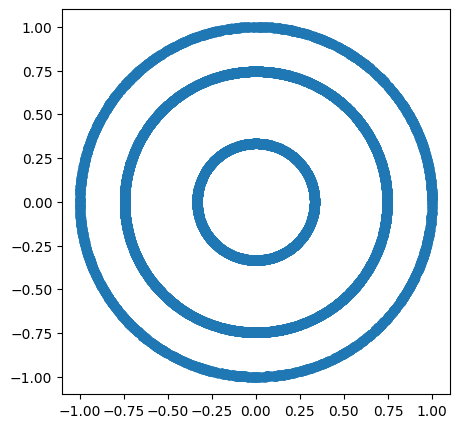

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import math

qam16_constellation = {
    0: (-3, -3), 1: (-3, -1), 2: (-3, 1), 3: (-3, 3),
    4: (-1, -3), 5: (-1, -1), 6: (-1, 1), 7: (-1, 3),
    8: (1, -3), 9: (1, -1), 10: (1, 1), 11: (1, 3),
    12: (3, -3), 13: (3, -1), 14: (3, 1), 15: (3, 3)
}

k = np.real( complex(1,0) * np.exp(1j*np.deg2rad(45)) ) / 3

print(k)

qam16_constellation = {key: (k * I, k * Q) for key, (I, Q) in qam16_constellation.items()}

symbols=np.array([complex(i,q) for i,q in qam16_constellation.values()])
print(symbols)

n_samples=10000

indices = np.random.randint(0, len(symbols), n_samples)
tx_symbols = symbols[indices]

freq_offset = 10*np.pi/180

n = np.arange(n_samples)
rx_symbols = tx_symbols * np.exp(1j * 2 * np.pi * freq_offset * n)

plt.figure(figsize=(5,5))
plt.scatter(np.real(rx_symbols), np.imag(rx_symbols))

Damping Ratio (ζ): 1.118033988749895
Overdamped (Slow Response): ζ>1
0
0.5132276137061872
0.20021920535471188
0.7025789836586656
0.24515017011995383
0.27628746612768956
0.45794635904651365
0.02570582561351971
0.9335367278785269
0.32367477233840086
0.3078077947162233
0.1171589976897562
0.7193395362503321
0.011858423553647832
0.3060991945566983
0.03747601478359907
0.0632737995722189
0.6633881264643283
0.12388525723813733
0.22669653799002795
0.2857648032732198
0.620657168497533
0.31378145548374586
0.1832171014996213
0.24715286344299178
0.6582398224380422
0.22135376700776893
0.06421505506746532
0.3815468332827461
0.037040588201993706
0.18546159832159284
0.06069772062331321
0.44745996233207275
0.09055987630892452
0.16597273058393738
0.23734680210610326
0.9712344988168993
0.28318830973101206
0.2150829066573635
0.06493649079097343
0.2877046443149369
0.29188684473019794
0.32568250861319725
0.1500788868565394
0.036160639834630026
0.8205294989413927
0.11189503882915036
0.555242996884357
0.119119

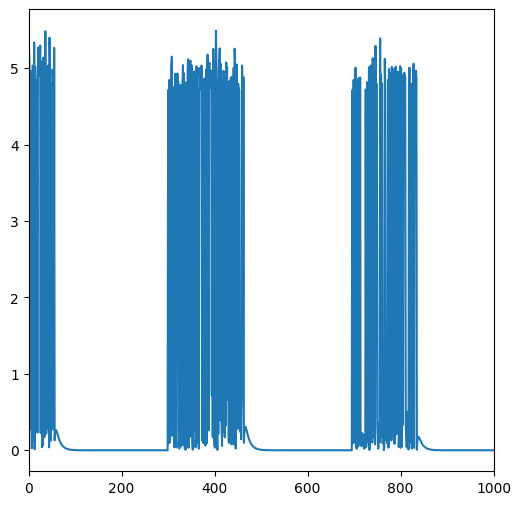

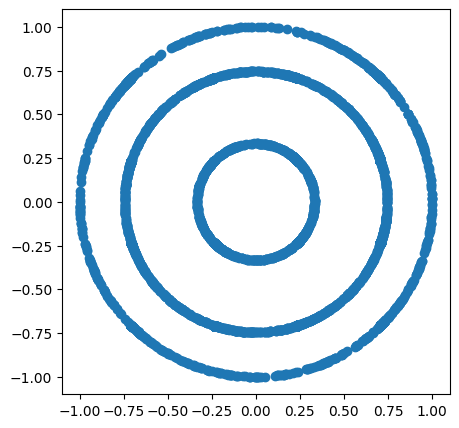

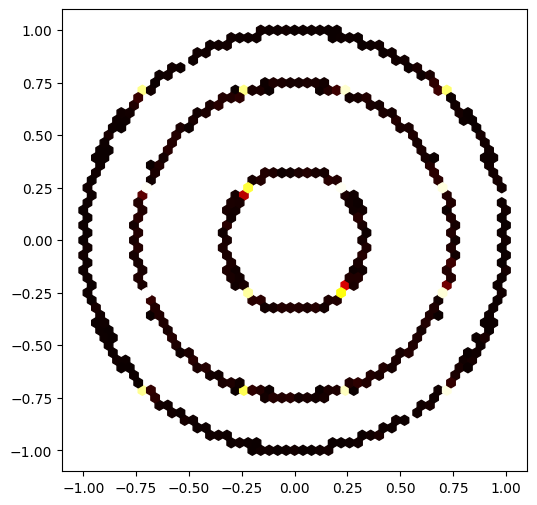

In [15]:
recovered_symbols = np.zeros(n_samples, dtype=complex)

Kp = 0.5  
Ki = 0.05 
zeta = Kp / (2 * np.sqrt(Ki))

print(f"Damping Ratio (ζ): {zeta}")
if(zeta < 1):
        print("Underdamped (Oscillatory Response): ζ<1")
elif (zeta == 1):
        print("Critically Damped (Fastest No-Overshoot Response): ζ=1")
else:
        print("Overdamped (Slow Response): ζ>1")

phase_nco = 0  
freq_nco = 0   
integrator = 0  
phase_errors = np.zeros(n_samples)

coeff_0_5   = np.array([ 0.00000000e+00,  1.08663477e+00, -2.79863347e-01, -8.26001880e-02,  8.05663681e-02, -2.37380471e-02,  3.23200598e-03, -1.71658583e-04])
coeff_5_25  = np.array([ 1.05131423e+00,  1.05555524e-01, -1.07802572e-02,  5.87491319e-04, -1.62972137e-05,  1.80676579e-07                                  ])
coeff_25_127= np.array([ 1.49527825e+00,  1.82146719e-03, -1.74287707e-05,  5.72763383e-08                                                                     ])

for i in range(n_samples):
        corrected_symbol = rx_symbols[i] * np.exp(-1j * phase_nco)

        closest_symbol = symbols[np.argmin(abs(symbols - corrected_symbol))]
        # phase_error = np.angle(corrected_symbol * np.conj(closest_symbol)) i have to modify this line
        symbol_phase_error = corrected_symbol * np.conj(closest_symbol) # here i have s(n)*e^(j(offset))
        # print(corrected_symbol)

        if np.imag(symbol_phase_error) == 0:
                q_i_div=0
        else:
                q_i_div = np.abs(np.imag(symbol_phase_error)/np.real(symbol_phase_error))

        print(q_i_div)
        # phase_error = math.atan(q_i_div) it works until here

        # atan aprox: 
        #       0-5: coeffs fxp: [ 0.00000000e+00  1.08663477e+00 -2.79863347e-01 -8.26001880e-02 8.05663681e-02 -2.37380471e-02  3.23200598e-03 -1.71658583e-04]
        #       5-25: coeffs fxp: [ 1.05131423e+00  1.05555524e-01 -1.07802572e-02  5.87491319e-04 -1.62972137e-05  1.80676579e-07]
        #       25-127: coeffs fxp: [ 1.49527825e+00  1.82146719e-03 -1.74287707e-05  5.72763383e-08]

        if q_i_div == 0:
                phase_error = 0
        elif q_i_div > 0 and q_i_div <= 5:
                phase_error = np.polyval(coeff_0_5[::-1], q_i_div)
        elif q_i_div > 5 and q_i_div <= 25:
                phase_error = np.polyval(coeff_5_25[::-1], q_i_div)
        elif q_i_div > 25 and q_i_div <= 127:
                phase_error = np.polyval(coeff_25_127[::-1], q_i_div)
        elif q_i_div > 127:
            phase_error = np.pi / 2  # Maximum atan value

        if np.real(symbol_phase_error) > 0 and np.imag(symbol_phase_error) > 0:
                phase_error = phase_error + 0
        elif np.real(symbol_phase_error) < 0 and np.imag(symbol_phase_error) > 0:
                phase_error = phase_error + np.deg2rad(90)
        elif np.real(symbol_phase_error) < 0 and np.imag(symbol_phase_error) < 0:
                phase_error = phase_error + np.deg2rad(180)
        elif np.real(symbol_phase_error) > 0 and np.imag(symbol_phase_error) < 0:
                phase_error = phase_error + np.deg2rad(270)
        

        phase_errors[i] = phase_error

        integrator += Ki * phase_error  
        freq_nco = Kp * phase_error + integrator  

        phase_nco += freq_nco  

        recovered_symbols[i] = corrected_symbol

plt.figure(figsize=(6,6))
plt.plot( range(n_samples), phase_errors)
plt.xlim(0,1000)

plt.figure(figsize=(5,5))
plt.scatter(np.real(recovered_symbols[2000:len(recovered_symbols)]),np.imag(recovered_symbols[2000:len(recovered_symbols)]))


plt.figure(figsize=(6, 6))
plt.hexbin(np.real(recovered_symbols), np.imag(recovered_symbols), gridsize=50, cmap="hot", mincnt=1)